# Plotting with Matplotlib

While UXarray's plotting API is written around the [HoloViz](https://holoviz.org/) stack of packages, plotting directly with Matplotlib is supported through the conversion to a `LineCollection` or `PolyCollection` object. This user guide will cover:
* Converting a `Grid` to a `LineCollection`
* Converting a `UxDataArray` to a `PolyCollection`
* Using Geographic Projections & Elements
* Handling periodic elements along the antimeridian

In [1]:
import uxarray as ux
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
base_path = "../../test/meshfiles/ugrid/outCSne30/"
grid_path = base_path + "outCSne30.ug"
data_path = base_path + "outCSne30_vortex.nc"

uxds = ux.open_dataset(grid_path, data_path)

## Visualize Grid Topology with `LineCollection`

The [`Grid.to_linecollection()`](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.Grid.to_linecollection.html#) method can be used to convert a `Grid` instance into a [`matplotlib.collections.LineCollection`](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.LineCollection) instance. It represents a collection of lines that represent the edges of an unstructured grid.

In [5]:
lc = uxds.uxgrid.to_linecollection()

Once we have converted our ``Grid`` to a ``LineCollection``, we can directly use Matplotlib.

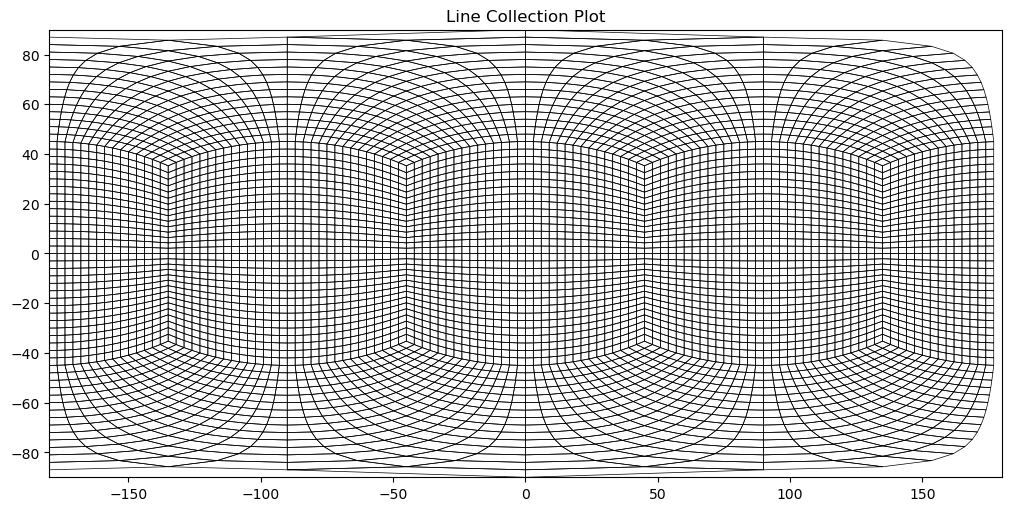

In [6]:
# control the width of each edge
lc.set_linewidth(0.5)

# set the color of each edge
lc.set_edgecolor("black")

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))
ax.add_collection(lc)

plt.title("Line Collection Plot")
plt.show()

## Visualize Data with `PolyCollection`

The [`Grid.to_polycollection()`](https://uxarray.readthedocs.io/en/latest/user_api/generated/uxarray.Grid.to_polycollection.html#) method can be used to convert a `UxDataArray` containing a face-centered data variable into a [`matplotlib.collections.PolyCollection`](https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PolyCollection) instance. It represents a collection of polygons that represent the faces of an unstructured grid, shaded using the values of the face-centered data variable.

In [7]:
pc = uxds["psi"].to_polycollection()

Just like with the ``LineCollection``, we can directly use Matplotlib to visualize our ``PolyCollection``

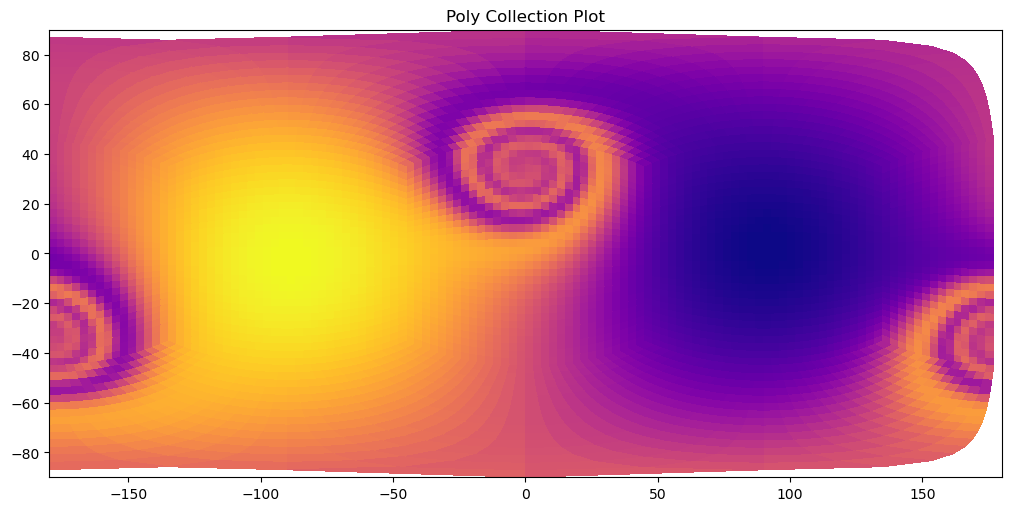

In [8]:
pc.set_antialiased(False)

pc.set_cmap("plasma")

fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)

ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))
ax.add_collection(pc)

plt.title("Poly Collection Plot")
plt.show()

## Geographic Projections & Elements

Both the `Grid.to_linecollection()` and `UxDataArray.to_polycollection()` methods accept an optional argument `projection` for setting a Cartopy projection. A full list of Cartopy projections can be found [here](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html).



In [9]:
projection = ccrs.Orthographic()

pc = uxds["psi"].to_polycollection(projection=projection, override=True)

Text(0.5, 1.0, 'PolyCollection Plot with Projection & Features')

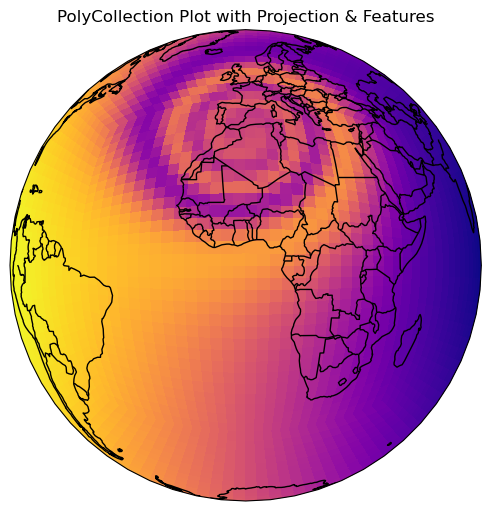

In [10]:
import cartopy.feature as cfeature

pc.set_antialiased(False)
pc.set_cmap("plasma")

fig, ax = plt.subplots(
    1,
    1,
    figsize=(10, 5),
    facecolor="w",
    constrained_layout=True,
    subplot_kw=dict(projection=projection),
)

# add geographic features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

ax.add_collection(pc)
ax.set_global()
plt.title("PolyCollection Plot with Projection & Features")

## Handling Periodic Elements

### Global Data

If your grid contains elements that cross the antimeridian, plotting them without any corrections will lead to artifacts, as can be observed in the first plot below. 

UXarray provides two ways of handling these elements:
- **Inclusion:** Periodic Elements will be included in the plot, without any processing done to them.
- **Exclusion:** Periodic Elements will be excluded from the plot, with no other corrections being done, indicated by setting `periodic_elements='exclude'`, this is the default.
- **Splitting:** Each periodic element is split into two across the antimeridian, indicated by setting `periodic_elements='split'`


```{warning}
Setting ``periodic_elements='split'`` will lead to roughly a 20 times perfromance hit compared to the other method, so it is suggested to only use this option for small grids.
```



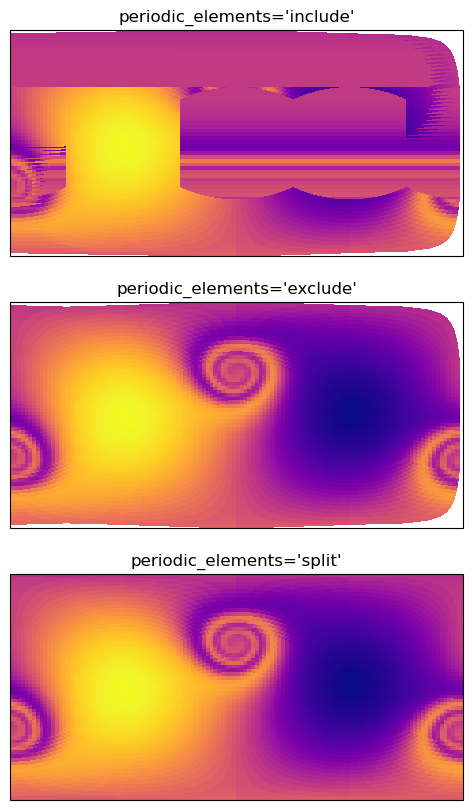

In [11]:
methods = ["include", "exclude", "split"]
poly_collections = [
    uxds["psi"].to_polycollection(periodic_elements=method) for method in methods
]


fig, axes = plt.subplots(
    nrows=3, figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax, pc, method in zip(axes, poly_collections, methods):
    pc.set_linewidth(0)
    pc.set_cmap("plasma")
    ax.set_xlim((-180, 180))
    pc.set_antialiased(False)
    ax.set_ylim((-90, 90))
    ax.add_collection(pc)
    ax.set_title(f"periodic_elements='{method}'")

### Regional Data

If you grid doesn't contain any periodic elements, it is always suggested to keep ``periodic_elements='ignore'`` for the best performance, as there is no difference in the resulting plots.

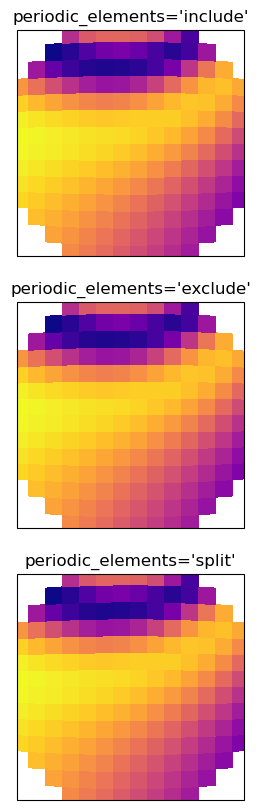

In [13]:
methods = ["include", "exclude", "split"]
poly_collections = [
    uxds["psi"]
    .subset.bounding_circle((0, 0), 20)
    .to_polycollection(periodic_elements=method)
    for method in methods
]


fig, axes = plt.subplots(
    nrows=3, figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
)

for ax, pc, method in zip(axes, poly_collections, methods):
    pc.set_linewidth(0)
    pc.set_cmap("plasma")
    pc.set_antialiased(False)
    ax.set_xlim((-20, 20))
    ax.set_ylim((-20, 20))
    ax.add_collection(pc)
    ax.set_title(f"periodic_elements='{method}'")